In [1]:
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
nltk.download('punkt')

# Function to read and preprocess text
def read_and_preprocess(files):
    corpus = []
    for file in files:
        with open(file, 'r') as f:
            text = f.read().lower()
            # Remove punctuation
            text = re.sub(r'[^\w\s]', '', text)
            # Tokenize
            tokens = word_tokenize(text)
            corpus.extend(tokens)
    return corpus

# Specify the files for the seven books
files = ['harry_potter(1)/HP1.txt', 'harry_potter(1)/HP2.txt', 'harry_potter(1)/HP3.txt', 'harry_potter(1)/HP4.txt']

# Preprocess the text
corpus = read_and_preprocess(files)


[nltk_data] Downloading package punkt to /Users/manisha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Create vocabulary and mappings
unique_words = list(set(corpus))
word_to_idx = {word: i for i, word in enumerate(unique_words)}
idx_to_word = {i: word for i, word in enumerate(unique_words)}

# Label encoding for corpus
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(corpus)

# One-hot encoding for integer encoded corpus
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [3]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 1
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [4]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")

Epoch 1/20


/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


17463/17463 ━━━━━━━━━━━━━━━━━━━━ 232s 13ms/step - accuracy: 0.0830 - loss: 6.6302 - val_accuracy: 0.1070 - val_loss: 6.1621
Epoch 2/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 223s 13ms/step - accuracy: 0.1144 - loss: 5.9684 - val_accuracy: 0.1100 - val_loss: 6.0942
Epoch 3/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 221s 13ms/step - accuracy: 0.1178 - loss: 5.7971 - val_accuracy: 0.1097 - val_loss: 6.1009
Epoch 4/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 224s 13ms/step - accuracy: 0.1216 - loss: 5.6719 - val_accuracy: 0.1091 - val_loss: 6.1057
Epoch 5/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 226s 13ms/step - accuracy: 0.1229 - loss: 5.5769 - val_accuracy: 0.1099 - val_loss: 6.1153
Epoch 6/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 225s 13ms/step - accuracy: 0.1227 - loss: 5.5045 - val_accuracy: 0.1080 - val_loss: 6.1453
Epoch 7/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 225s 13ms/step - accuracy: 0.1230 - loss: 5.4467 - val_accuracy: 0.1068 - val_loss: 6.1665
Epoch 8/20
17463/17463 ━━━━━━━━━━━━━━━━━━━━ 225s 13ms/step - accur

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "voldemort"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'voldemort':
pettigrew: 0.4948
dumbledore: 0.4731
lupin: 0.4676
snape: 0.4618
karkaroff: 0.4543
youknowwho: 0.4278
werewolves: 0.4117
weirder: 0.4105
wormtail: 0.4070
errol: 0.4069


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "voldemort"
top_related_words = get_most_similar_words(target_word, top_n=20)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'voldemort':
pettigrew: 0.4948
dumbledore: 0.4731
lupin: 0.4676
snape: 0.4618
karkaroff: 0.4543
youknowwho: 0.4278
werewolves: 0.4117
weirder: 0.4105
wormtail: 0.4070
errol: 0.4069
escaped: 0.4033
rita: 0.4025
mcgonagall: 0.4013
fungi: 0.4009
eighteen: 0.3989
fulfilling: 0.3932
quirrell: 0.3926
ireland: 0.3882
crying: 0.3862
contorted: 0.3855


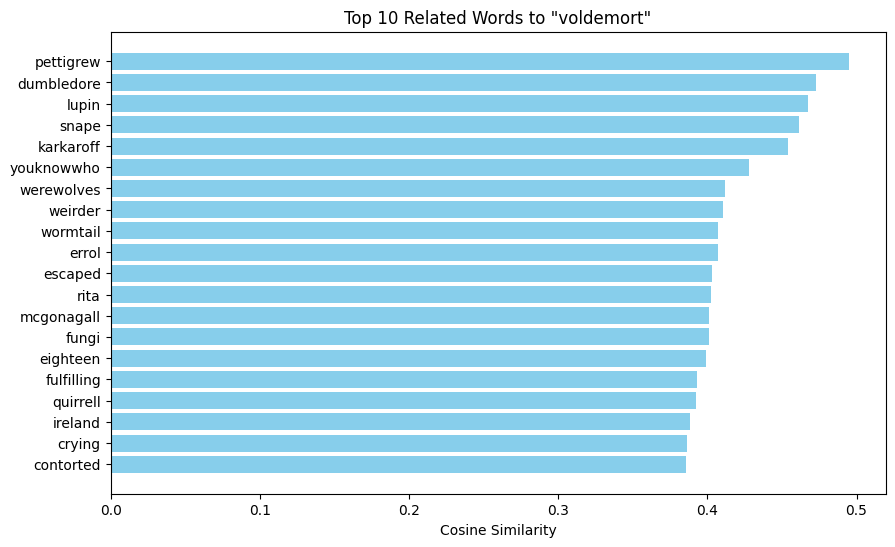

In [13]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


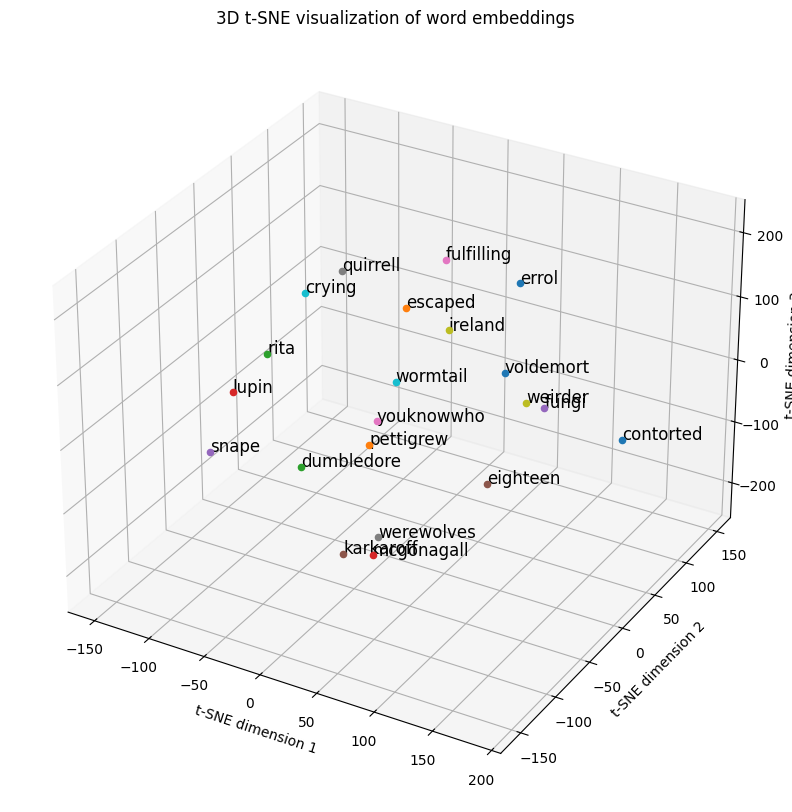

In [14]:
from sklearn.manifold import TSNE
# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

## Increase window size

In [15]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 5
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [16]:
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

initializer = tf.keras.initializers.RandomNormal(mean=0.05, stddev=0.05)
# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None, kernel_initializer = initializer)(embedding_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax', kernel_initializer = initializer)(flatten_layer)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")

/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1010s 12ms/step - accuracy: 0.0497 - loss: 6.7956 - val_accuracy: 0.0509 - val_loss: 6.7337
Epoch 2/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1095s 13ms/step - accuracy: 0.0517 - loss: 6.6749 - val_accuracy: 0.0508 - val_loss: 6.7118
Epoch 3/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1112s 13ms/step - accuracy: 0.0527 - loss: 6.6292 - val_accuracy: 0.0507 - val_loss: 6.7435
Epoch 4/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1139s 13ms/step - accuracy: 0.0529 - loss: 6.5979 - val_accuracy: 0.0503 - val_loss: 6.7948
Epoch 5/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1113s 13ms/step - accuracy: 0.0531 - loss: 6.5856 - val_accuracy: 0.0502 - val_loss: 6.8177
Epoch 6/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1119s 13ms/step - accuracy: 0.0530 - loss: 6.5691 - val_accuracy: 0.0497 - val_loss: 6.7988
Epoch 7/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1159s 13ms/step - accuracy: 0.0526 - loss: 6.5505 - val_accuracy: 0.0496 - val_loss: 6.8042
Epoch 8/20
87312/87312 ━━━━━━━━━━━━━━━━━━━━ 1169

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=20):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=20)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
ron: 0.4843
he: 0.4493
hagrid: 0.4418
heroworshipped: 0.4327
dumbledore: 0.4284
bugs: 0.3916
ignition: 0.3872
vill: 0.3828
tutting: 0.3716
sher: 0.3715
winky: 0.3669
oh: 0.3666
humble: 0.3652
neville: 0.3631
distractedly: 0.3587
aglow: 0.3564
rosier: 0.3510
fred: 0.3491
lawbreakers: 0.3489
recruiting: 0.3475


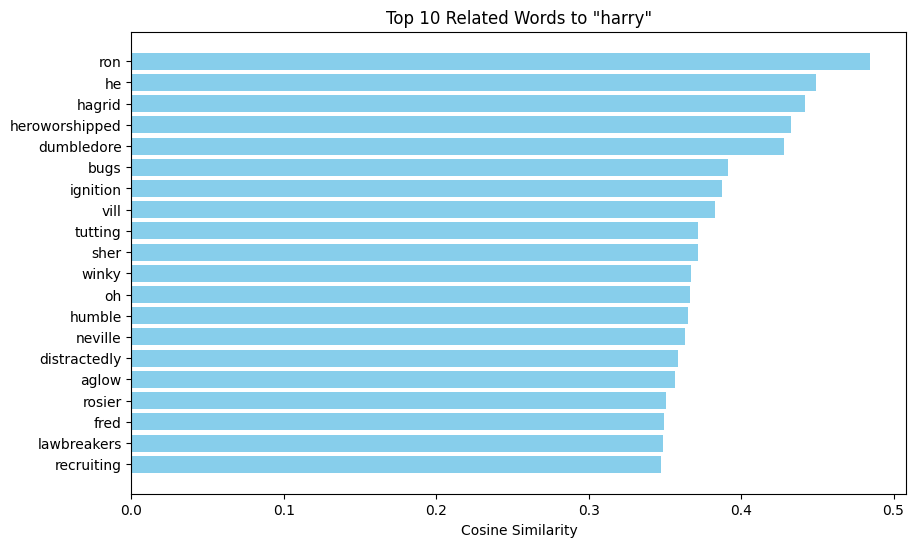

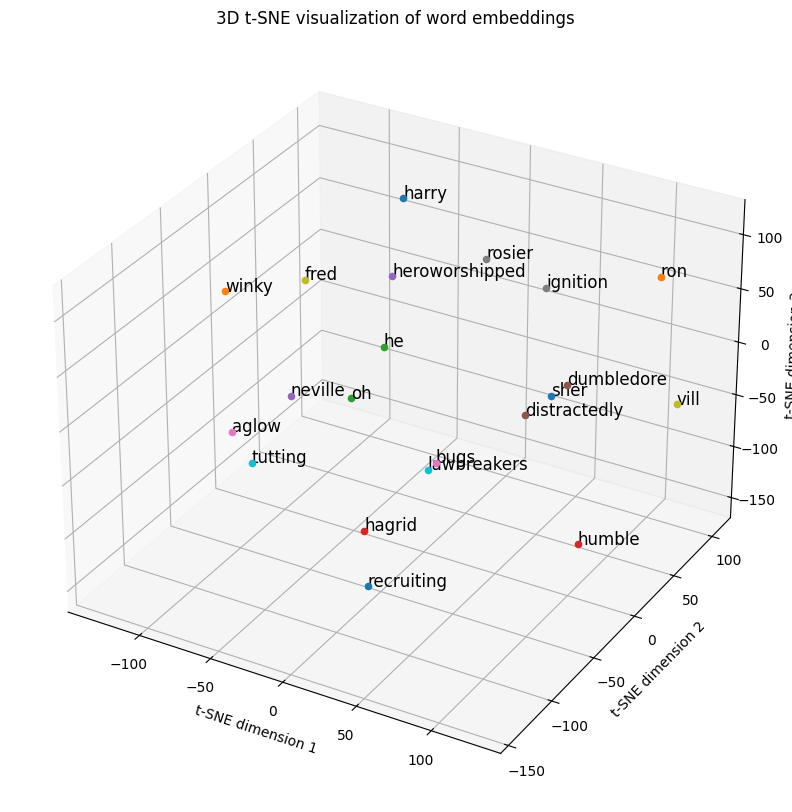

In [34]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()